In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import required packages
import pandas as pd
import numpy as np

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# models
# models
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# metrics
import time
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.axes_style('white')
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# load the data into a dataframe
df = pd.read_csv('../data/water_potability.csv')

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
# shape: rows, columns
display(df.shape)

# info of the dataset
df.info()

(3276, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


0    1998
1    1278
Name: Potability, dtype: int64


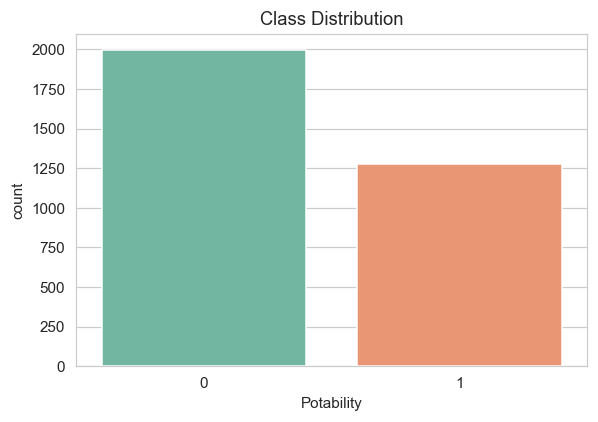

In [5]:
# class distribution
print(df['Potability'].value_counts())

# plot the class distribution
plt.figure(dpi=110)
chart = sns.countplot(x="Potability", data=df, palette="Set2")
axes = chart.axes
axes.set_title('Class Distribution')
axes.set_xlabel('Potability')
plt.show()

In [6]:
# count duplicate datapoints
df.duplicated().sum()

0

In [7]:
# count null values(NaN) for each column
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

# Feature Importance Analysis

In [8]:
# drop all null value rows for feature selection
# shape before dropping rows with null values
display(df.shape)

df_no_null_features = df.dropna(axis=0)

# shape after dropping rows with null values
display(df_no_null_features.shape)

# separate independent and dependent features
X = df_no_null_features.drop('Potability', axis=1)
y = df_no_null_features['Potability']

(3276, 10)

(2011, 10)

In [9]:
# feature importance analysis using XGBoost
# instantiate an XGBoost model
model = XGBClassifier(n_estimators=100)

# training start
print('training XGBoost...')
start_time = time.time()

# train the model
model.fit(X, y)

# training end
end_time = time.time()
print('training completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

training XGBoost...
training completed: 1.11 seconds


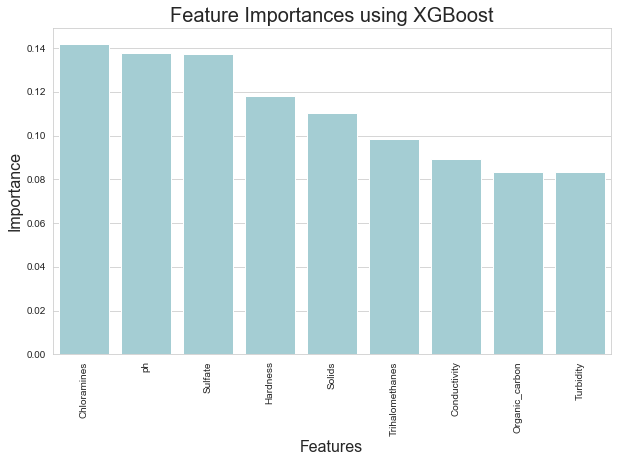

In [10]:
# create a mapping of features and feature importance
imp_features_xgb = pd.DataFrame(
    {
        'features': X.columns,
        'importance': model.feature_importances_
    }
)

# sort the features by their feature importance in descending order
imp_features_xgb = imp_features_xgb.sort_values(by='importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10,6))

ax = sns.barplot(x='features', y='importance', data=imp_features_xgb, color='#9cd3db')

plt.title('Feature Importances using XGBoost',  size=20)
plt.xlabel('Features', size=16)
plt.ylabel('Importance', size=16)
plt.xticks(rotation='vertical')

plt.show()

## To do:
1. Split dataset into train, validation, test
2. Perform kNN imputation to cosntruct two different datasets.

In [11]:
# train-validation-test split (60-20-20)
# train-test split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Potability'], random_state=42)

# train-validation
df_train, df_valid = train_test_split(df_train, test_size=0.25, stratify=df_train['Potability'], random_state=42)

# rest index
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# size of train-validation-test sets
print('train:',df_train.shape[0])
print('valid:',df_valid.shape[0])
print('test:',df_test.shape[0])

# save train set
# df_train.to_csv('../data/train_data.csv', index=False)

# save validation set
# df_valid.to_csv('../data/valid_data.csv', index=False)

# save test set
# df_test.to_csv('../data/test_data.csv', index=False)

train: 1965
valid: 655
test: 656


# Mean Imputation

In [12]:
# extract independent features: x
# will undergo mean imputation
X_train = df_train.drop('Potability', axis=1)
X_valid = df_valid.drop('Potability', axis=1)
X_test = df_test.drop('Potability', axis=1)

# shape of the copy sets
X_train.shape, X_valid.shape, X_test.shape

((1965, 9), (655, 9), (656, 9))

In [13]:
# null counts of original data sets
print('train set:', df_train.isna().sum().sum())
print('valid set:', df_valid.isna().sum().sum())
print('test set:', df_test.isna().sum().sum())

train set: 852
valid set: 294
test set: 288


In [14]:
# null value imputation using mean
# instantiate a SimpleImputer with mean imputation strategy
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# training start
print('training mean imputer...')
start_time = time.time()

# fit the imputer to the train set
mean_imputer.fit(X_train)

# training end
end_time = time.time()
print('training completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

training mean imputer...
training completed: 0.00 seconds


In [15]:
# perform imputation on dataset
# train set
# imputation start
print('performing mean imputation on train set...')
start_time = time.time()

# perform mean imputation on train set
df_mean_train = pd.DataFrame(mean_imputer.transform(X_train), columns=X_train.columns)
df_mean_train['Potability'] = df_train['Potability']

# imputation end
end_time = time.time()
print('imputation completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

# validation set
# imputation start
print('\nperforming mean imputation on validation set...')
start_time = time.time()

# perform mean imputation on train set
df_mean_valid = pd.DataFrame(mean_imputer.transform(X_valid), columns=X_valid.columns)
df_mean_valid['Potability'] = df_valid['Potability']

# imputation end
end_time = time.time()
print('imputation completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

# test set
# imputation start
print('\nperforming mean imputation on test set...')
start_time = time.time()

# perform mean imputation on train set
df_mean_test = pd.DataFrame(mean_imputer.transform(X_test), columns=X_test.columns)
df_mean_test['Potability'] = df_test['Potability']

# imputation end
end_time = time.time()
print('imputation completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

performing mean imputation on train set...
imputation completed: 0.00 seconds

performing mean imputation on validation set...
imputation completed: 0.00 seconds

performing mean imputation on test set...
imputation completed: 0.00 seconds


In [16]:
# verifying null count of each mean-imputed sets
print('train set:', df_mean_train.isna().sum().sum())
print('valid set:', df_mean_valid.isna().sum().sum())
print('test set:', df_mean_test.isna().sum().sum())

train set: 0
valid set: 0
test set: 0


# kNN Imputation

In [17]:
# extract independent features: x
# will undergo kNN imputation
X_train = df_train.drop('Potability', axis=1)
X_valid = df_valid.drop('Potability', axis=1)
X_test = df_test.drop('Potability', axis=1)

# shape of the copy sets
X_train.shape, X_valid.shape, X_test.shape

((1965, 9), (655, 9), (656, 9))

In [18]:
# total null values in original data sets
print('train set:', df_train.isna().sum().sum())
print('valid set:', df_valid.isna().sum().sum())
print('test set:', df_test.isna().sum().sum())

train set: 852
valid set: 294
test set: 288


In [19]:
# null value imputation using kNN imputer
# instantiate a knn imputer with k=3
knn_imputer = KNNImputer(n_neighbors=3, weights='distance')

# training start
print('training kNN imputer...')
start_time = time.time()

# train the imputer on the train set
knn_imputer.fit(X_train)

# training end
end_time = time.time()
print('training completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

training kNN imputer...
training completed: 0.00 seconds


In [20]:
# perform imputation on dataset
# train set
# imputation start
print('performing kNN imputation on train set...')
start_time = time.time()

# transform or perform imputation on the dataset
df_knn_train = pd.DataFrame(knn_imputer.transform(X_train), columns=X_train.columns)
df_knn_train['Potability'] = df_train['Potability']

# imputation end
end_time = time.time()
print('imputation completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

# validation set
# imputation start
print('\nperforming kNN imputation on validation set...')
start_time = time.time()
# transform or perform imputation on the dataset
df_knn_valid = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)
df_knn_valid['Potability'] = df_valid['Potability']

# imputation end
end_time = time.time()
print('imputation completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

# test set
# imputation start
print('\nperforming kNN imputation on test set...')
start_time = time.time()

# transform or perform imputation on the dataset
df_knn_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)
df_knn_test['Potability'] = df_test['Potability']

# imputation end
end_time = time.time()
print('imputation completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

performing kNN imputation on train set...
imputation completed: 0.08 seconds

performing kNN imputation on validation set...
imputation completed: 0.03 seconds

performing kNN imputation on test set...
imputation completed: 0.03 seconds


In [21]:
# verifying null count of each kNN-imputed sets
print('train set:', df_knn_train.isna().sum().sum())
print('valid set:', df_knn_valid.isna().sum().sum())
print('test set:', df_knn_test.isna().sum().sum())

train set: 0
valid set: 0
test set: 0


## Models + Imputed Dataset Combinations:
- Logistic Regression with:
    - kNN imputed data
    - Mean imputed data
- Linear Support Vector Machine with:
    - kNN imputed data
    - Mean imputed data
- Gaussian Naive Bayes with:
    - kNN imputed data
    - Mean imputed data
- XGBoost Classifier with:
    - kNN imputed data
    - Mean imputed data

In [23]:
# separate datasets into independent and dependent features: X & y
# knn imputed data sets
# independent features: X
# train set
X_knn_train = df_knn_train.drop('Potability', axis=1)

# valid set
X_knn_valid = df_knn_valid.drop('Potability', axis=1)

# test set
X_knn_test = df_knn_test.drop('Potability', axis=1)

# mean imputed data sets
# train set
X_mean_train = df_mean_train.drop('Potability', axis=1)

# valid set
X_mean_valid = df_mean_valid.drop('Potability', axis=1)

# test set
X_mean_test = df_mean_test.drop('Potability', axis=1)\

# dependent feature: y
# train
y_train = df_train['Potability']

# validation
y_valid = df_valid['Potability']

# test
y_test = df_test['Potability']

## Univariate Analysis:
---
## ph:

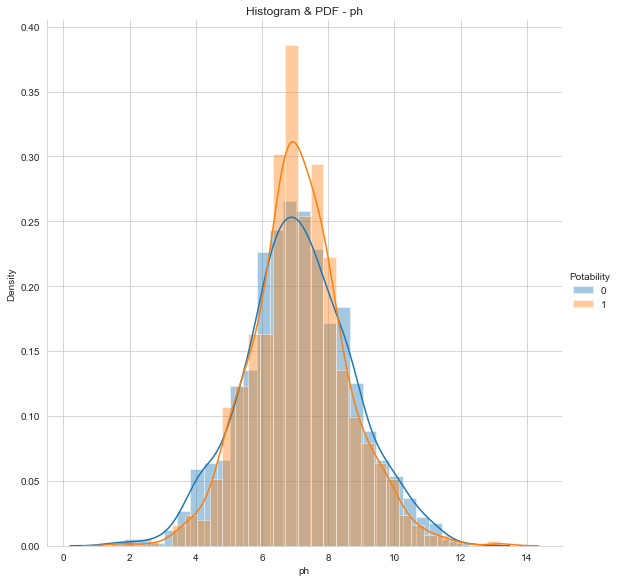

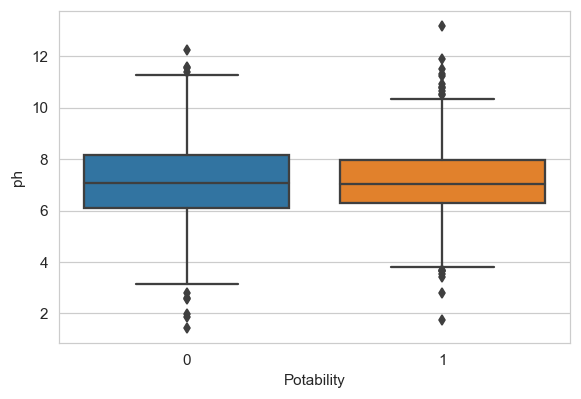

In [22]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'ph').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - ph')
axes[0].set_xlabel('ph')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='ph', data=df_train)
plt.show()

## Hardness:

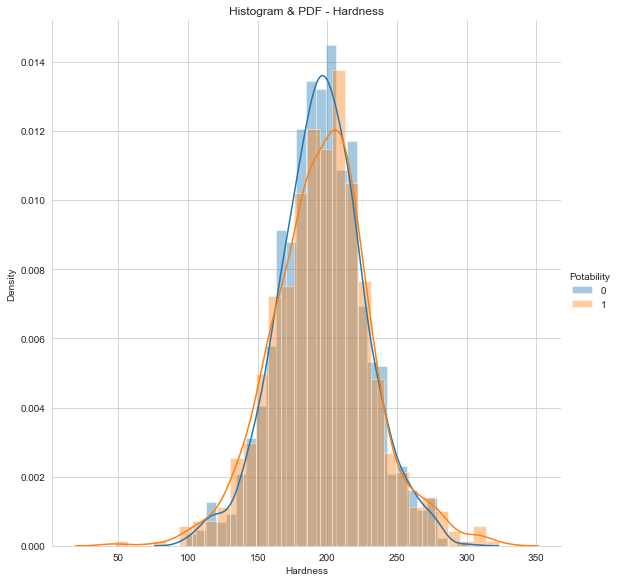

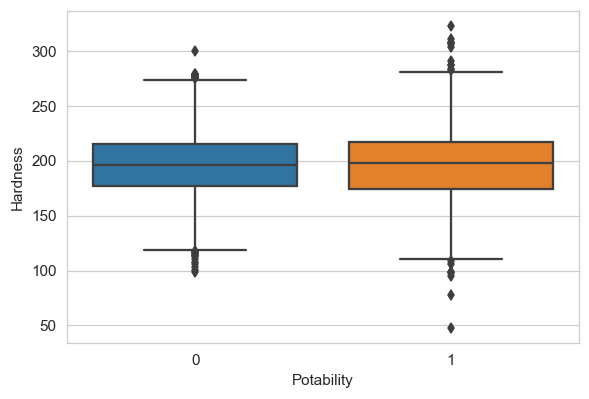

In [23]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Hardness').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Hardness')
axes[0].set_xlabel('Hardness')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Hardness', data=df_train)
plt.show()

## Solids:

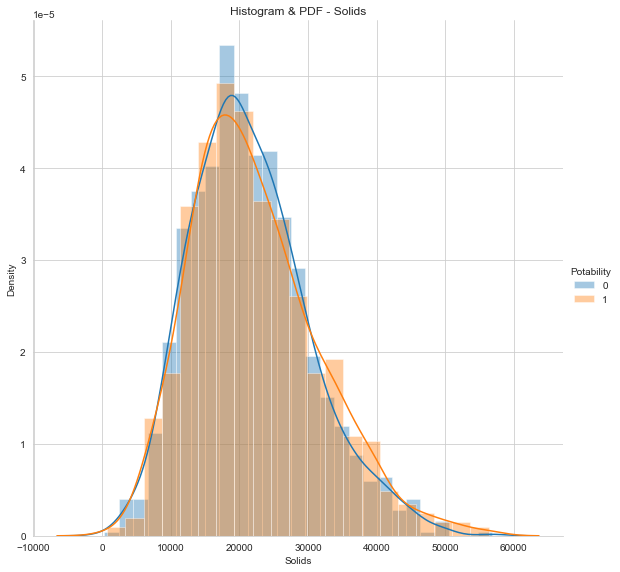

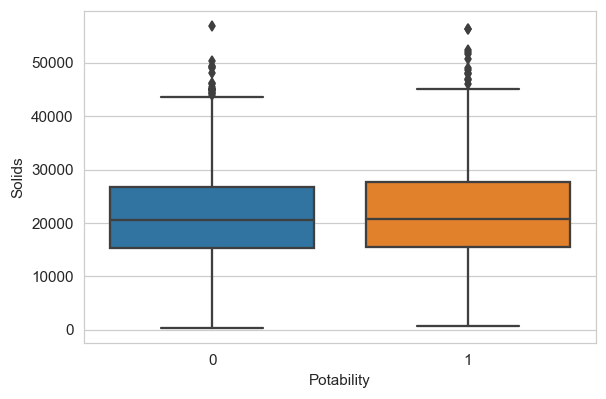

In [24]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Solids').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Solids')
axes[0].set_xlabel('Solids')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Solids', data=df_train)
plt.show()

## Chloramines:

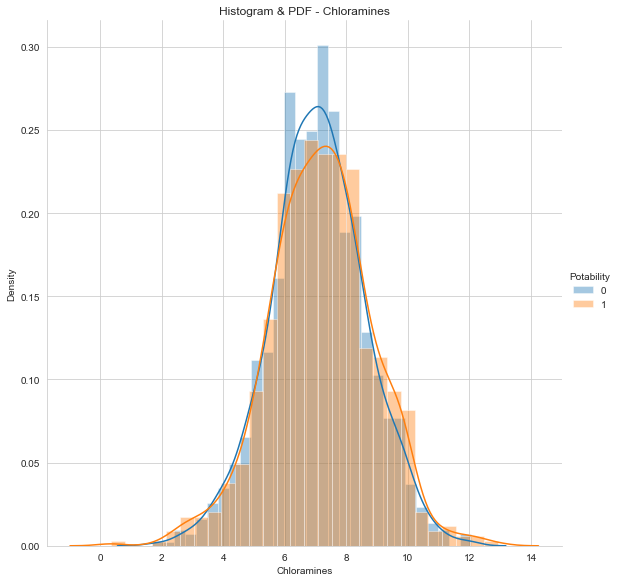

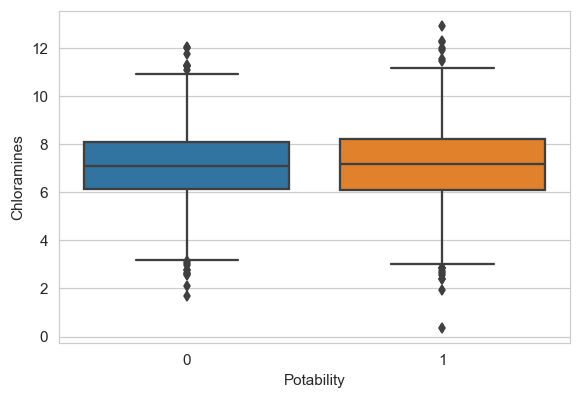

In [25]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Chloramines').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Chloramines')
axes[0].set_xlabel('Chloramines')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Chloramines', data=df_train)
plt.show()

## Sulfate:

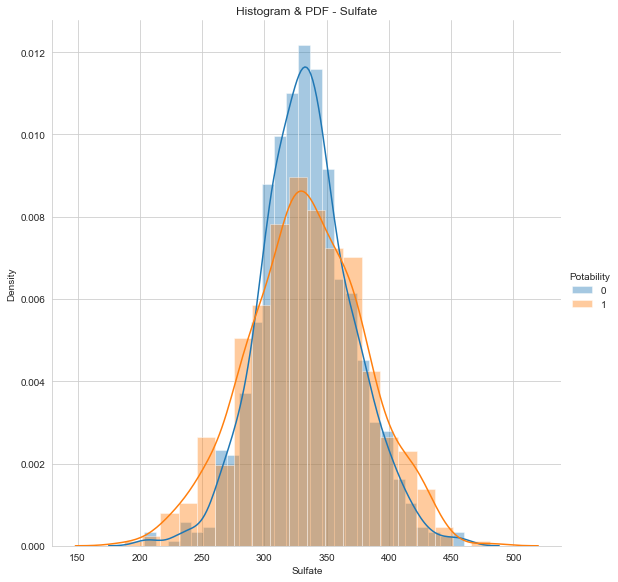

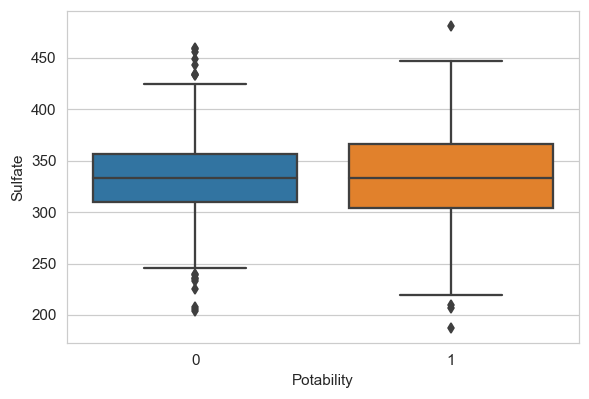

In [26]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Sulfate').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Sulfate')
axes[0].set_xlabel('Sulfate')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Sulfate', data=df_train)
plt.show()

## Conductivity:

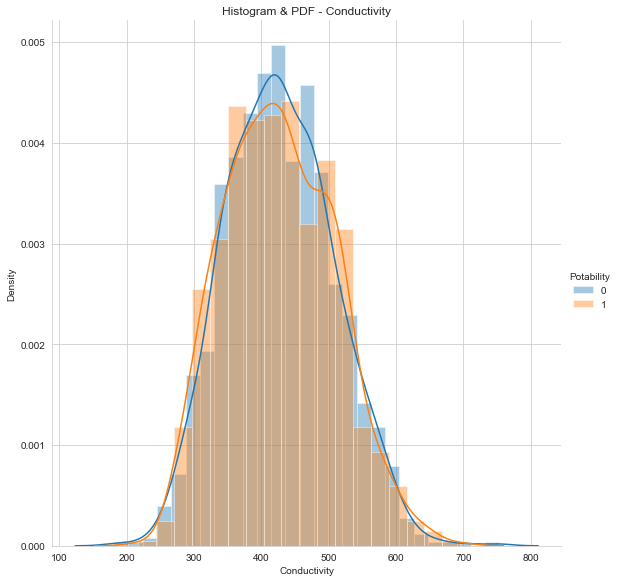

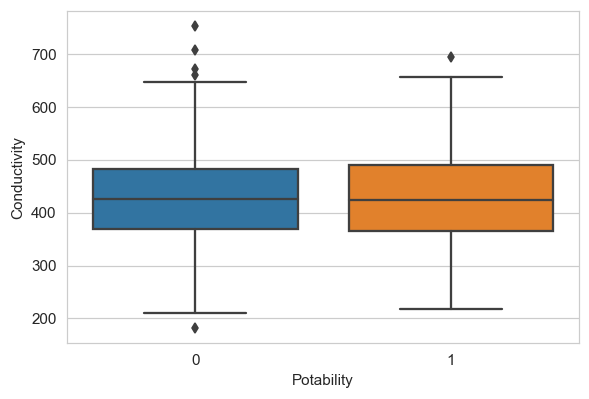

In [27]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Conductivity').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Conductivity')
axes[0].set_xlabel('Conductivity')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Conductivity', data=df_train)
plt.show()

## Organic Carbon-

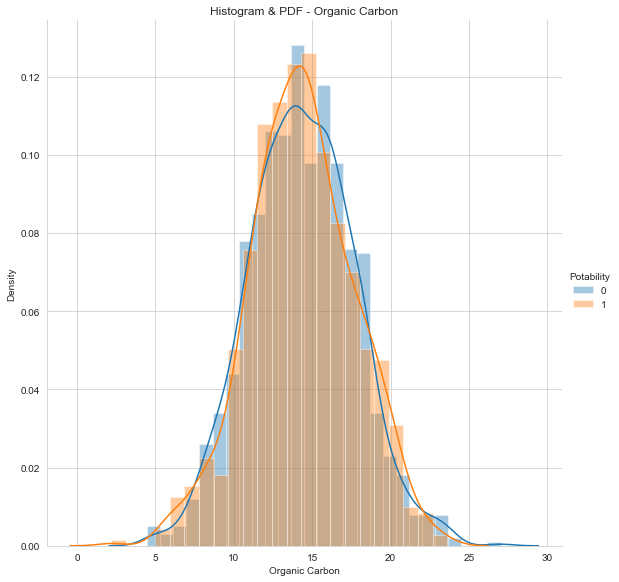

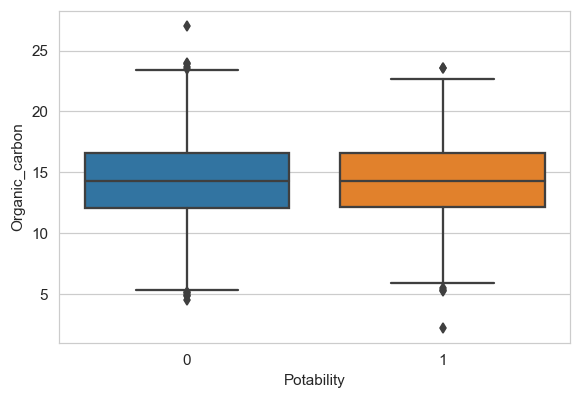

In [28]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Organic_carbon').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Organic Carbon')
axes[0].set_xlabel('Organic Carbon')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Organic_carbon', data=df_train)
plt.show()

## Trihalomethanes:

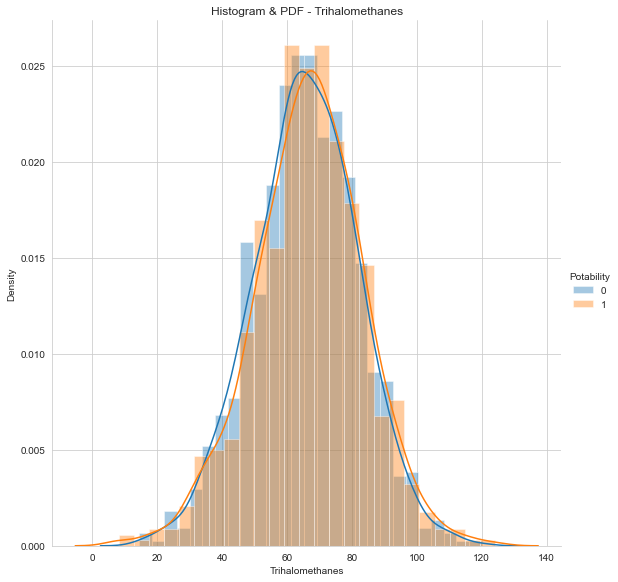

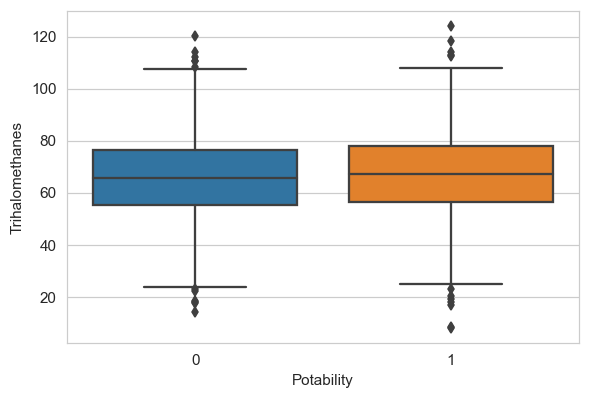

In [29]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Trihalomethanes').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Trihalomethanes')
axes[0].set_xlabel('Trihalomethanes')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Trihalomethanes', data=df_train)
plt.show()

## Turbidity:

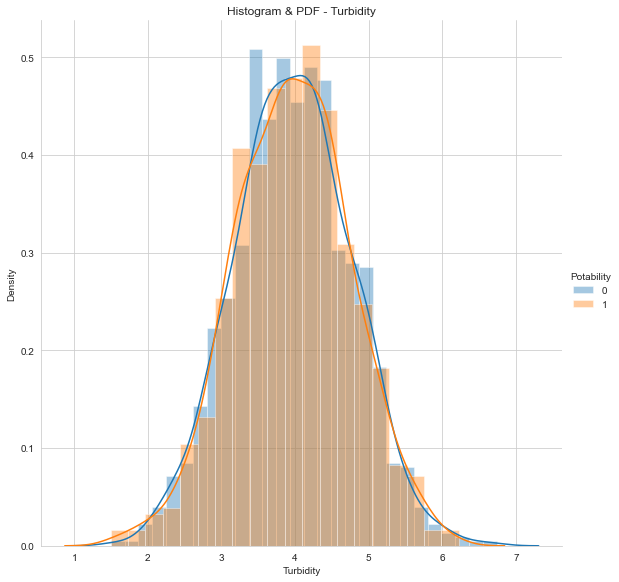

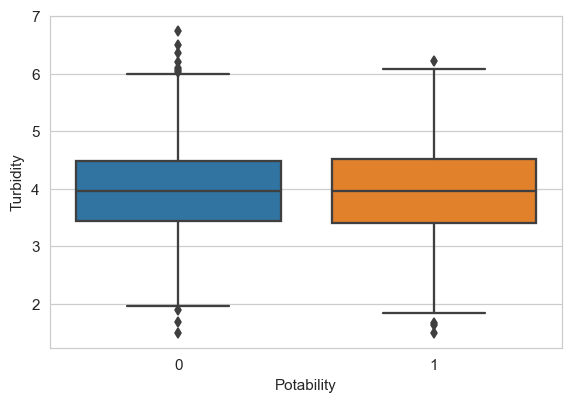

In [30]:
chart = sns.FacetGrid(df_train, hue='Potability', height=8).map(sns.distplot, 'Turbidity').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Turbidity')
axes[0].set_xlabel('Turbidity')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Turbidity', data=df_train)
plt.show()

## Observation:
- There is complete overlap between the class labels for each feature, which makes either of the features useless individually.
- A combination of some or all the features will be required to solve the problem.

## Bivariate Analysis:

---

## Pair Plot:

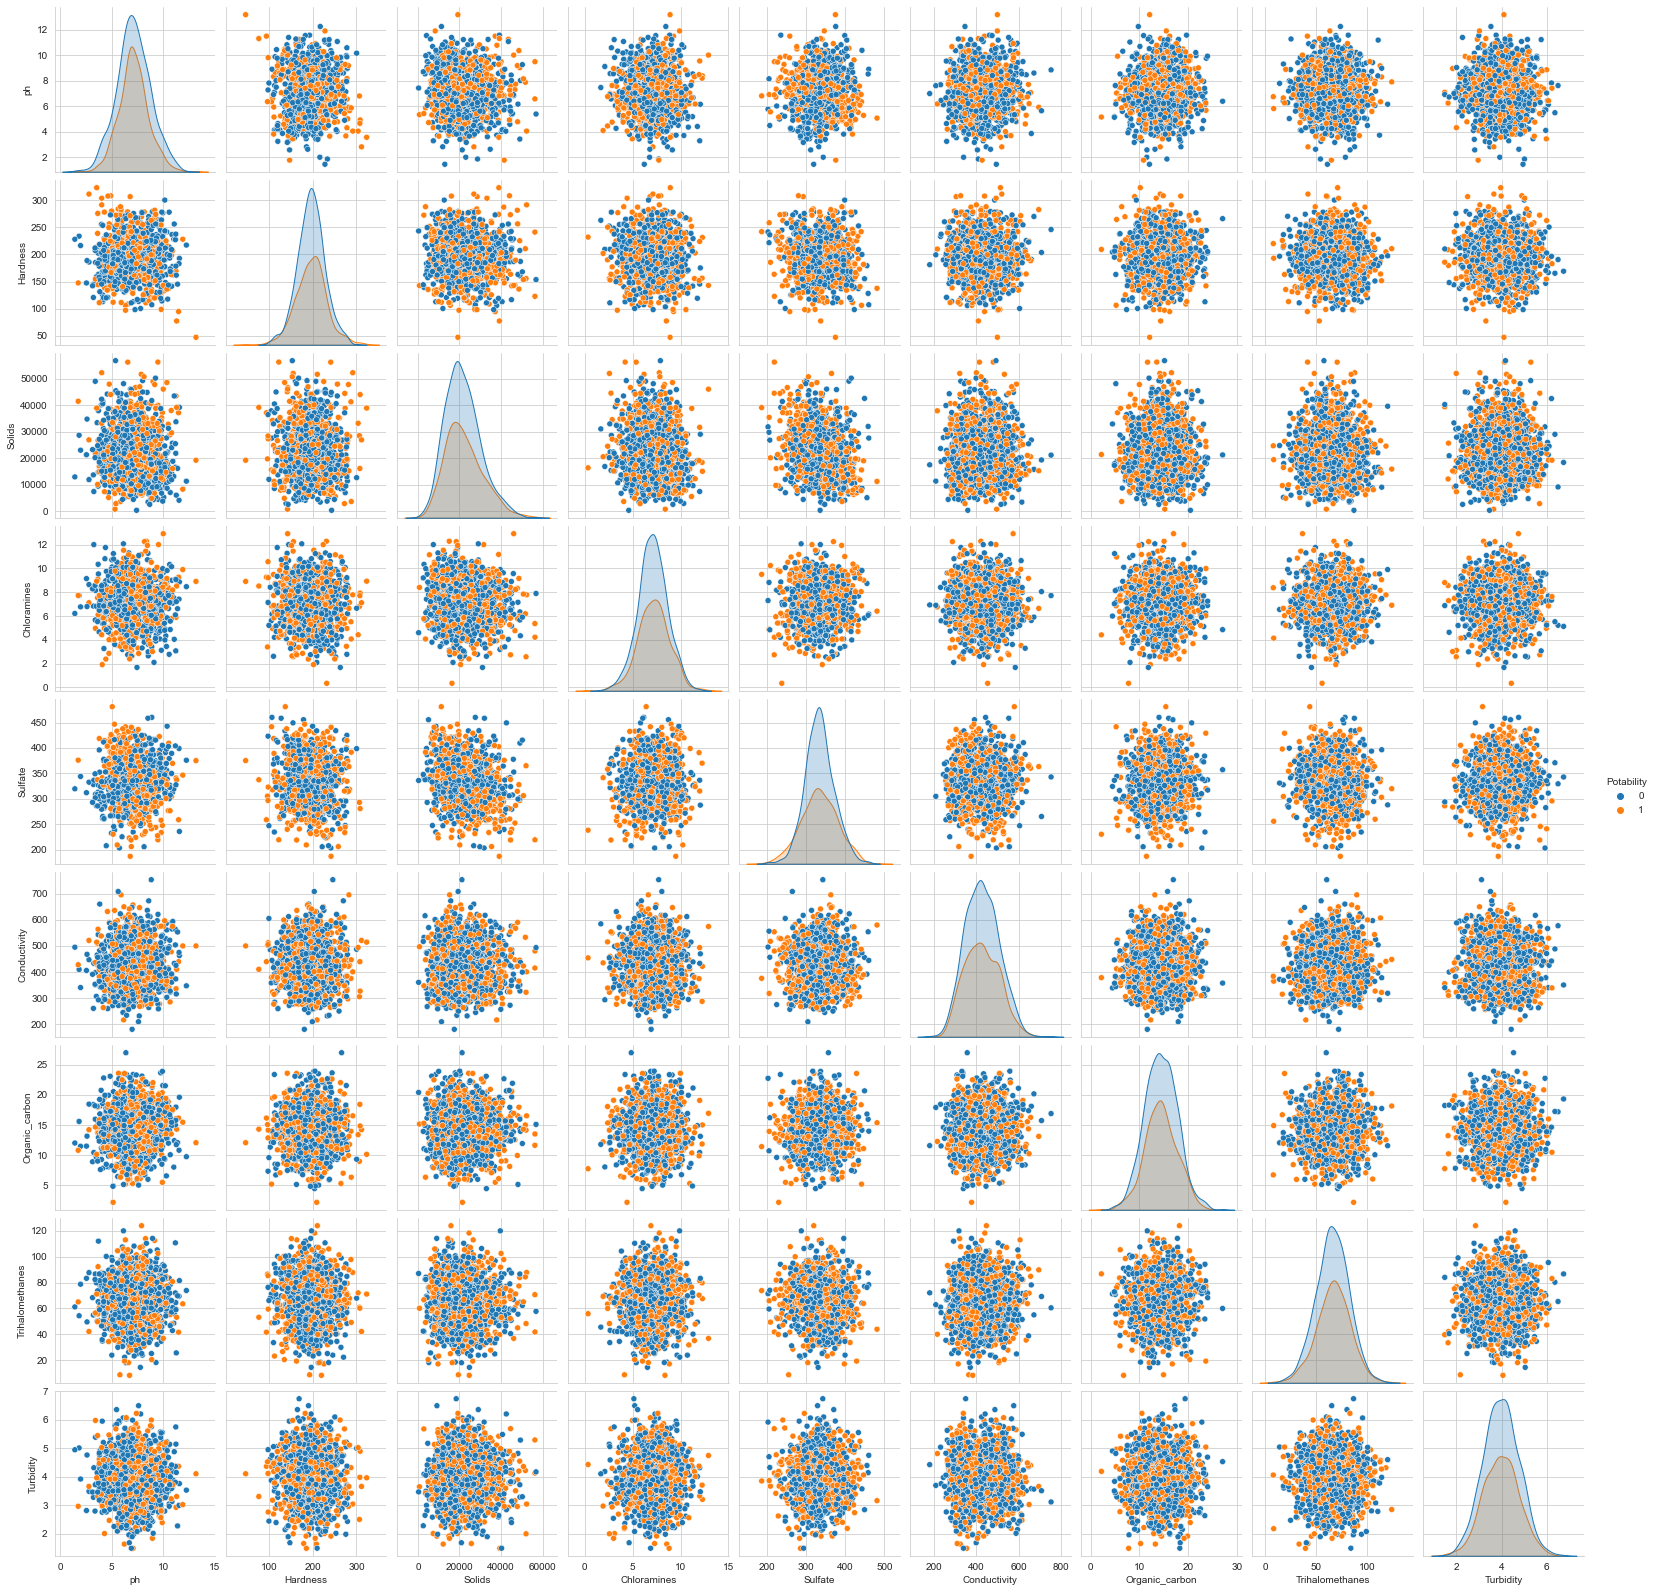

In [31]:
sns.pairplot(df_train, hue="Potability")
plt.show()

## Attribute Correlation:

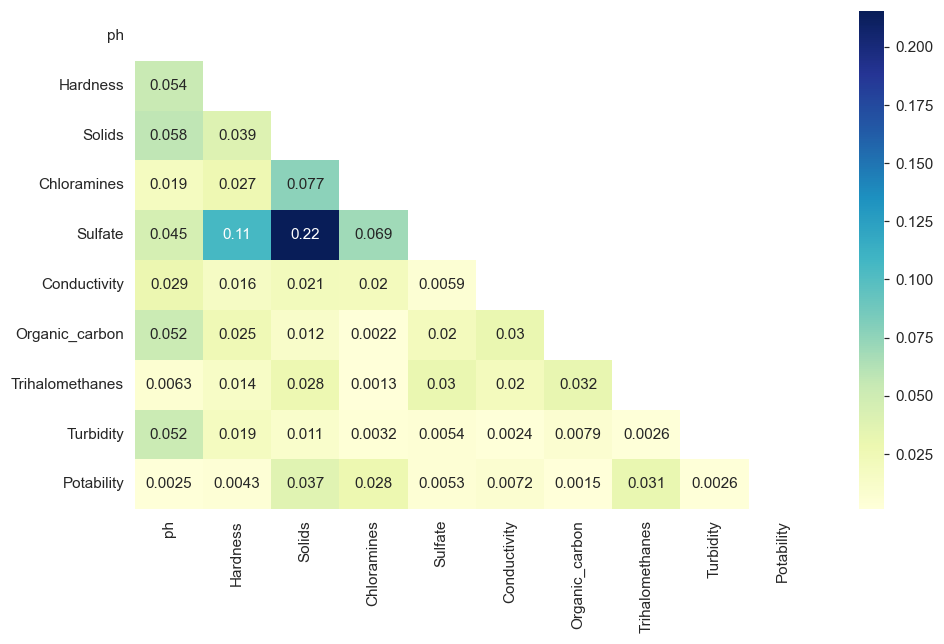

In [32]:
# mask for heatmap
mask = np.zeros_like(df_train.corr())
mask[np.triu_indices_from(mask)] = True

# plot feature correlations
plt.figure(figsize=(10,6), dpi=110)
sns.heatmap(df_train.corr().abs(), annot=True, cmap="YlGnBu", mask=mask)
plt.show()

## Observation: 
- No significant correlation between any of the columns, hence there are no redundant features that can be dropped.
- The highest correlation is 15%(approx) that exists between the features: **Solids** & **Sulfate**.
- Other pairs of features with considerable correlation are:
    - **ph** & **Hardness**
    - **ph** & **Solids**
    - **Hardness** & **Sulfate**
    - **Solids** & **Chloramines**

## Scatter Plot:
---
### Solids vs Sulfate-

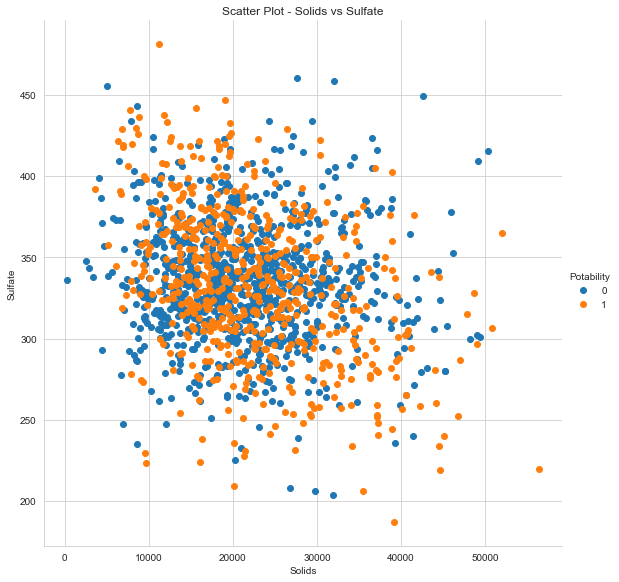

In [33]:
chart = sns.FacetGrid(df_train, hue="Potability", height=8).map(plt.scatter, "Solids", "Sulfate").add_legend()
axes = chart.axes.flatten()
axes[0].set_title("Scatter Plot - Solids vs Sulfate")
axes[0].set_xlabel("Solids")
axes[0].set_ylabel("Sulfate")
plt.show()

## Observation:
- The pair of features with the maximum correlation are unable to separate the datapoints clearly in 2D.